# Measuring Momentum



In [19]:
from statsmodels import regression
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader.data as pdr
yf.pdr_override()


## Moving Average Crossover

A very common way to obtain a momentum signal is to look for moving average crossovers. This means computing two moving averages of different lengths, and waiting for one to cross the other. The direction of the cross will indicate the direction of the momentum.

We'll demonstrate this on some real asset data.

[*********************100%%**********************]  9 of 9 completed


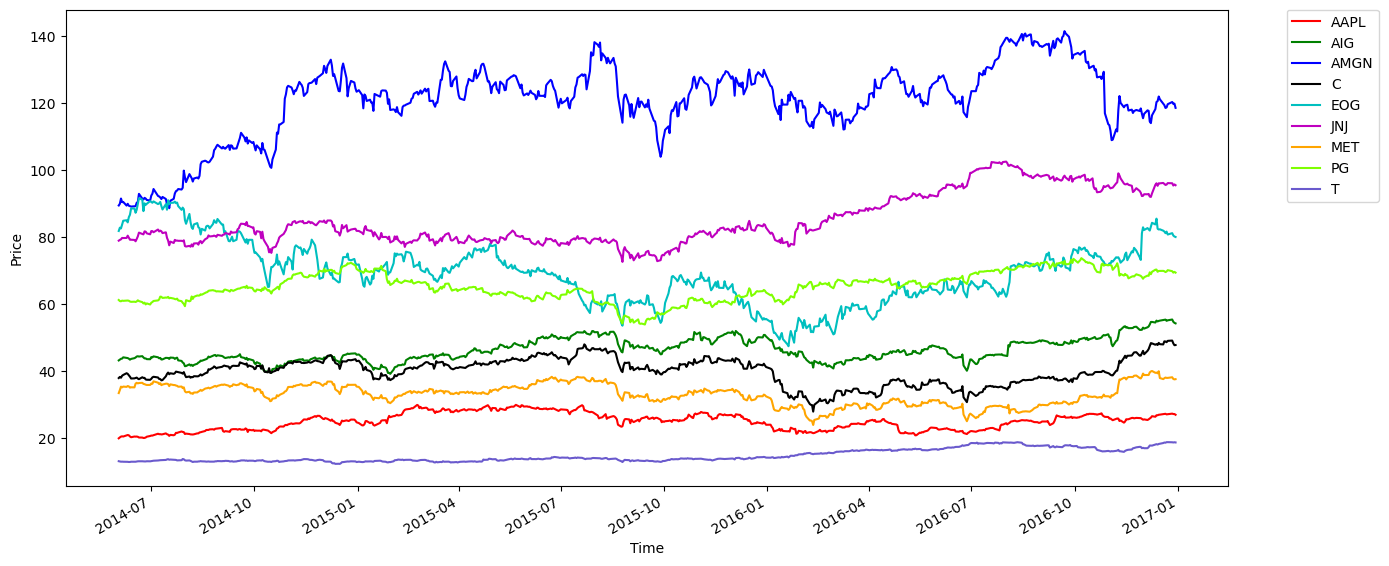

In [18]:
# Fetch prices data for 9 stocks of different sectors
start = '2014-06-01'
end = '2016-12-31'
assets = ['AAPL', 'AIG', 'C', 'T', 'PG', 'JNJ', 'EOG', 'MET', 'AMGN']
data = pdr.get_data_yahoo(assets, start, end)
prices = data['Adj Close']

prices.plot(figsize=(15,7), color=['r', 'g', 'b', 'k', 'c', 'm', 'orange',
                                  'chartreuse', 'slateblue', 'silver'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()

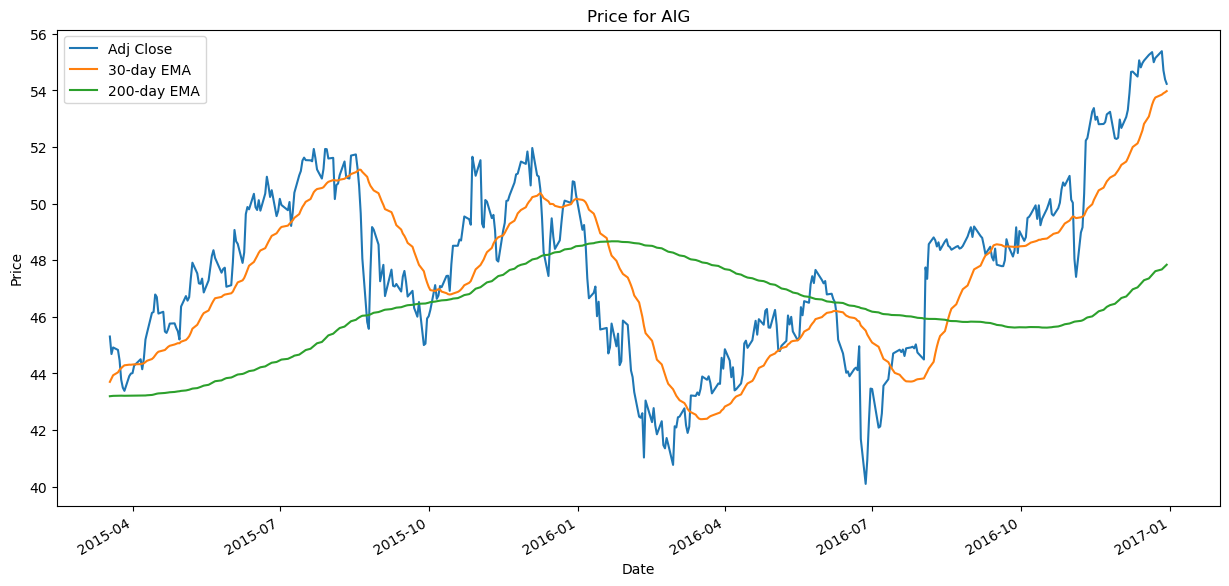

In [26]:
# choose a stock
ticker = 'AIG'
# calculate 30 and 200-day moving averages
stock = prices[ticker]
short_mavg = stock.rolling(window=30, center=False).mean()
long_mavg = stock.rolling(window=200, center=False).mean()

stock[200:].plot(label='Adj Close',figsize=(15,7))
short_mavg[200:].plot(label='30-day EMA')
long_mavg[200:].plot(label='200-day EMA')
plt.ylabel('Price')
plt.title(f'Price for {ticker}')
plt.legend()
plt.show()

We can see here that there are two crossing points once both averages are fully populated. The first seems to be following downturn and second suggests upturn.


### Choosing Moving Average Lengths

### Overfitting

The signal depends on the winodws chosen  for your moving average crossover strategy. There can be better windows leading to better robust optimization techniques. It is easy to overfit your moving window lengths



## Moving Average Crossover Ribbons

Another approach is to draw many moving averages at a time, and attempt to extract statistics from the shape of the 'ribbon' rather than any two moving averages.

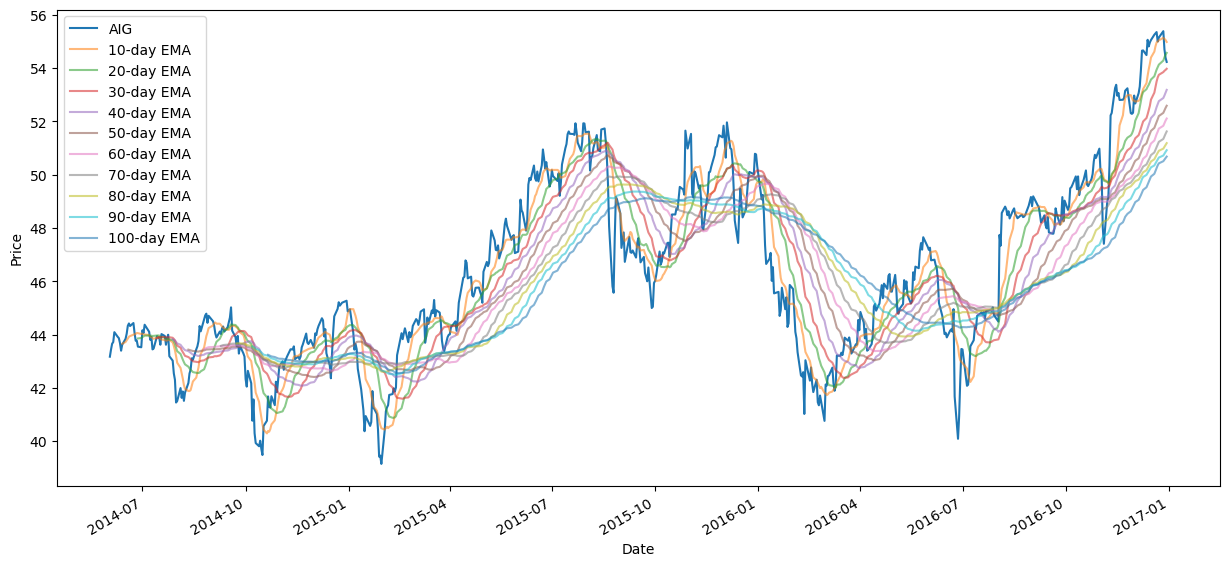

In [27]:
stock.plot()

# container for MA
rolling_means = {}

# loop over window widths
for i in np.linspace(10, 100, 10):
    X = stock.rolling(window=int(i),center=False).mean()
    rolling_means[i] = X
    X.plot(figsize=(15,7), alpha = 0.55,ylabel='Price',label=f'{int(i)}-day EMA')
    
rolling_means = pd.DataFrame(rolling_means).dropna()
plt.legend()
plt.show()

### Signal from Ribbons

Here are a few quantitative measures of ribbon shape. This will in turn give us a trading signal.


#### Distance Metric

We can use a distance metric to see how far away from some given ranking our ribbon is. Here we check against a 1-10 ranking for the windows of 10d to 100d.

**Buy Signal**
* A perfectly increasing order of ribbons (i.e 10d MA < 20d MA <... 100d MA) results in a score of 0. This can be a signal to buy to go long.

**Sell Signal**
* A perfectly decreasing order of ribbons (i.e 10d MA > 20d MA >... 100d MA) results in a score of 1. This can be a signal to sell to go short.

Resource: [This lecture slides](http://theory.stanford.edu/~sergei/slides/www10-metrics.pdf).

We calculate the rank of two window MAs and calculate the Hamming distance:

From [wikipedia](https://en.wikipedia.org/wiki/Hamming_distance):

Hamming distance between two strings or vectors of equal length is the number of positions at which the corresponding symbols are different. In other words, it measures the minimum number of substitutions required to change one string into the other.

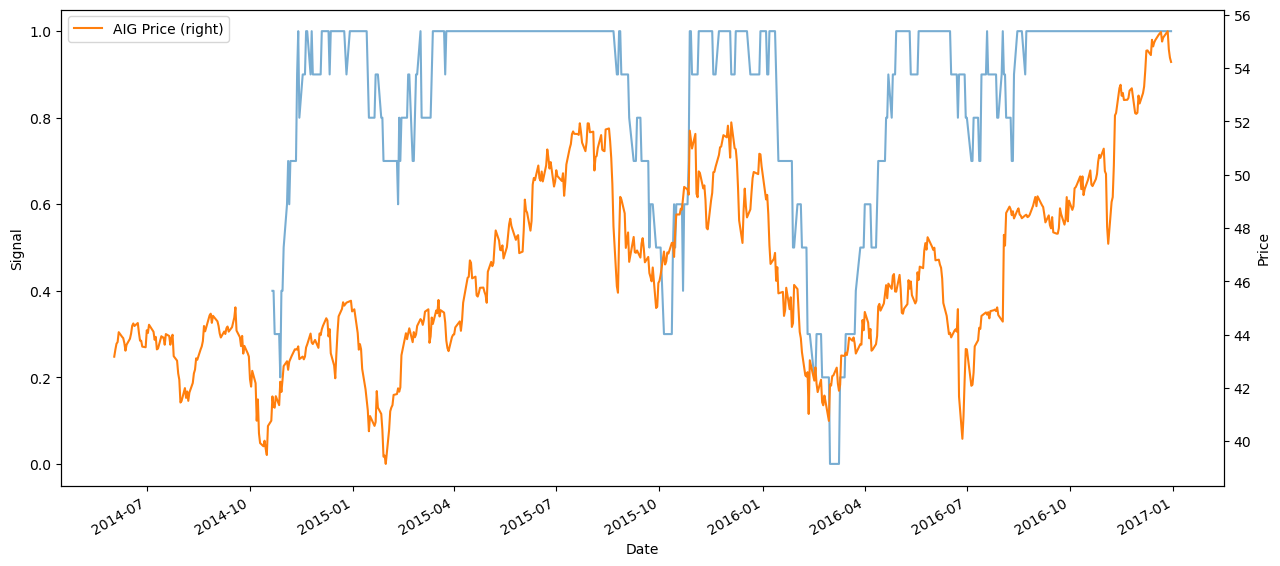

In [46]:
# container for score
scores = pd.Series(index=stock.index)

# loop over dates
for date in rolling_means.index:
    # get the rolling mean
    mavg_values = rolling_means.loc[date]

    # get ranking of each value of mean at a particular date
    ranking = stats.rankdata(mavg_values.values)

    # get hamming distance between the ranked values
    d = distance.hamming(ranking, range(1, 11))

    scores[date] = d

fig,ax = plt.subplots(1,1,figsize=(15,7))
# Normalize the  score
scores.plot(ax=ax, alpha=0.6,label='Signal',ylabel='Signal')
stock.plot(ax=ax,secondary_y=True,label=f'{ticker} Price',ylabel='Price')
plt.legend()
plt.show()

The Buy Signal (Signal=0) is reached at April 2016 and Sell Signal (Signal=1) is hit at multiple times. The signal is noisy.

### Correlation metric 

We can use correlation matrix for getting signal

**Buy Signal**
A perfectly increasing order of ribbons (i.e 10d MA < 20d MA <... 100d MA) results in a score of 1. This can be a signal to buy to go long.

**Sell Signal**
A perfectly decreasing order of ribbons (i.e 10d MA > 20d MA >... 100d MA) results in a score of -1. This can be a signal to sell to go short.

We use spearmananr function to get correlation coefficient

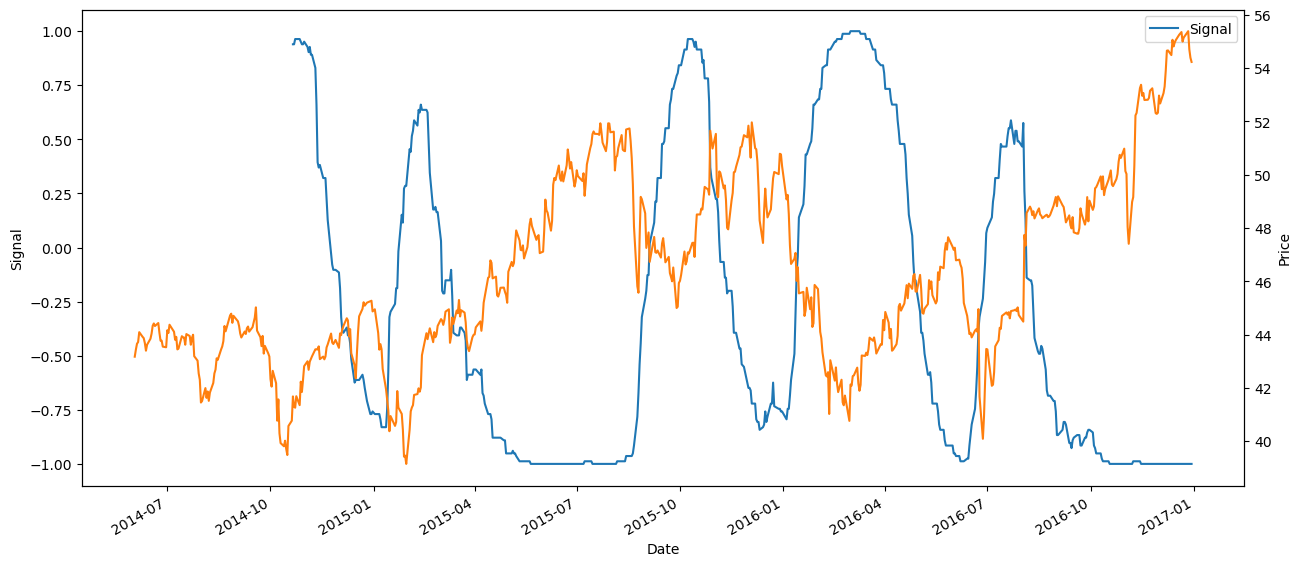

In [45]:
scores = pd.Series(index=stock.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    ranking = stats.rankdata(mavg_values.values)

    # Use correlation matrix with range(1,11)
    d, _ = stats.spearmanr(ranking, range(1, 11))
    scores[date] = d

fig,ax = plt.subplots(1,1,figsize=(15,7))

scores.plot(ax=ax, label = 'Signal',ylabel='Signal')
stock.plot(ax=ax,secondary_y=True, alpha=1,label=f'{ticker} Price',ylabel='Price')
ax.legend()
plt.show()

### Measuring Thickness

We can also just take the range of values at any given time to monitor the thickness of the ribbon. 

Converging ribbons (low thickness) means buy and diverging indicates sell. Combine this with difference in Moving Averages to buy or sell.

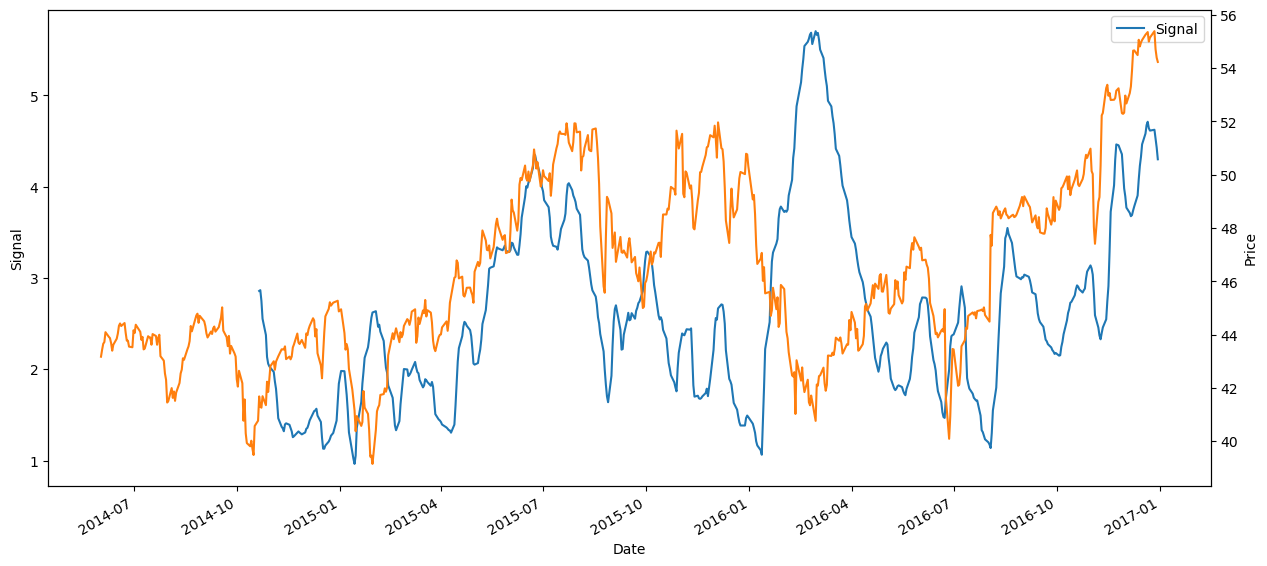

In [44]:
scores = pd.Series(index=stock.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    # get thickness of the range
    d = np.max(mavg_values) - np.min(mavg_values)
    scores[date] = d
    

fig,ax = plt.subplots(1,1,figsize=(15,7))
(scores).plot(ax=ax,label='Signal',ylabel='Signal')
stock.plot(ax=ax,label=f'{ticker} Price',secondary_y=True,ylabel='Price')
ax.legend()
plt.show()

## Measures of Momentum 

In this This paper http://arxiv.org/pdf/1208.2775.pdf. The authors define 4 different measures, called $p^{(1)}$, $p^{(0)}$, $p^{(2)}$, and $p^{(3)}$.

The definition of momentum can be related to phyiscs with analogy:

$x(t)\sim log P$ where P is price of stock
$v(t) \sim log R$ where R is return of stock 

$m$ can be many things, for example volume of the stock

The different momenta are then defined (for a lookback window $k$) as:

$$p^{(0)}(t) = \sum_{i=0}^{k-1} v(t-i)$$
$$p^{(1)}(t) = \sum_{i=0}^{k-1} m(t-i) v(t-i)$$
$$p^{(2)}(t) = \frac{\sum_{i=0}^{k-1} m(t-i) v(t-i)}{\sum_{i=0}^{k-1} m(t-i)}$$
$$p^{(3)}(t) = \frac{\mu(v(t-k+1),\ldots, v(t))}{\sigma(v(t-k+1),\ldots, v(t))} $$


In [59]:
# lookback window
k = 30

# get one year of data
start = '2014-01-01'
end = '2015-01-01'

stock = pdr.get_data_yahoo(ticker, start, end)

# get Prices aka positions
x = np.log(stock['Adj Close'])
# get Returns aka velocity
v = x.diff()
# get volume aka mass
m =  stock['Volume']

# get momentums
p0 = v.rolling(window=k, center=False).sum()
p1 = m*v.rolling(window=k, center=False).sum()
p2 = p1/m.rolling(window=k, center=False).sum()
p3 = v.rolling(window=k, center=False).mean()/v.rolling(window=k, center=False).std()

[*********************100%%**********************]  1 of 1 completed


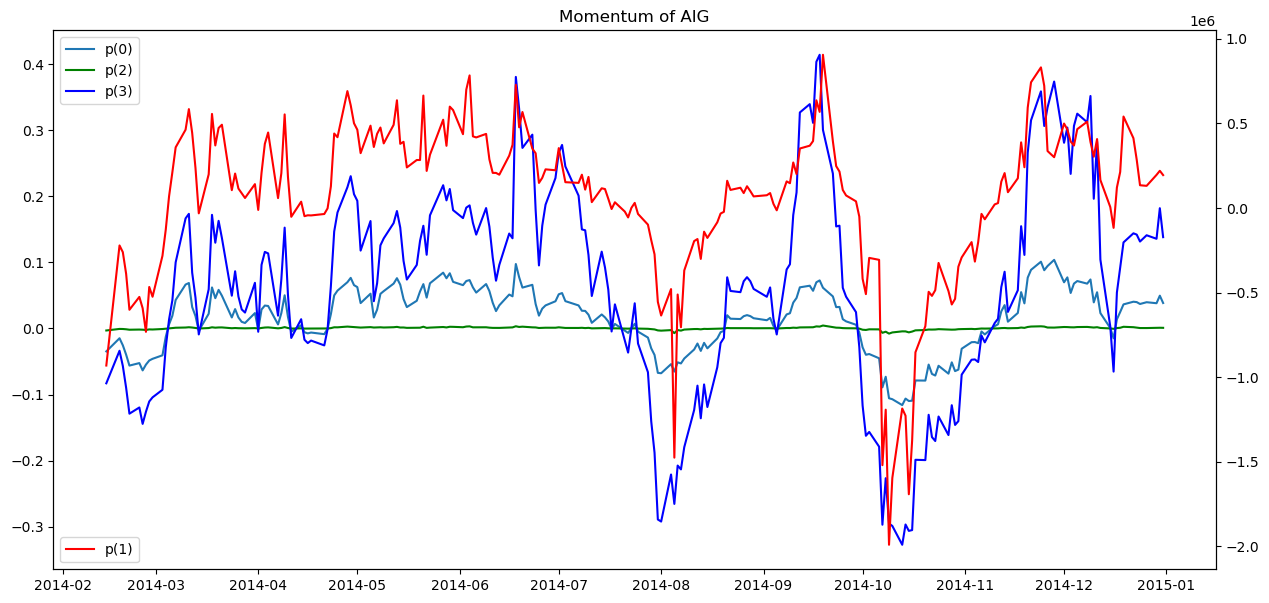

In [61]:
fig,ax1 = plt.subplots(1,1,figsize=(15,7))

ax1.plot(p0,label='p(0)')
ax1.plot(p2,'g',label='p(2)')
ax1.plot(p3,'b',label='p(3)')
# get twin axis
ax2 = ax1.twinx()
ax2.plot(p1,'r',label='p(1)')

ax1.set_title(f'Momentum of {ticker}')
ax1.legend(loc=2)
ax2.legend(loc=3)

plt.show()

We can change the lookback periods and different definition of mass to get the momentums.
